# HuBMAP - Hacking the Human Vasculature
The goal of this competition is to segment instances of microvascular structures, including capillaries, arterioles, and venules. The task is to create a model trained on 2D PAS-stained histology images from healthy human kidney tissue slides.

# Libraries

In [1]:
pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.12.0
    Uninstalling accelerate-0.12.0:
      Successfully uninstalled accelerate-0.12.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U transformers --no-index --find-links=file:///kaggle/input/huggingfaces/transformers

Looking in links: file:///kaggle/input/huggingfaces/transformers


In [3]:
!pip install pipreqsnb

  Preparing metadata (setup.py) ... - \ done
  Created wheel for pipreqsnb: filename=pipreqsnb-0.2.4-py3-none-any.whl size=4141 sha256=7abc7980d3e0c74254a5d5b83bed04c2b9ab7130b3a65e5e8df260d52dfcd048
  Stored in directory: /root/.cache/pip/wheels/c3/1b/47/ca78a979321cb4bf9e812da5157fb754712f43d094bc60bf61
Successfully built pipreqsnb


In [4]:
!pipreqsnb '/kaggle/working'

Exception occurred while working on file /kaggle/working/__notebook__.ipynb, cell 3/42
Traceback (most recent call last):
  File "/opt/conda/bin/pipreqsnb", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/pipreqsnb/pipreqsnb.py", line 130, in main
    raise e
  File "/opt/conda/lib/python3.10/site-packages/pipreqsnb/pipreqsnb.py", line 126, in main
    imports += get_import_string_from_source(source)
  File "/opt/conda/lib/python3.10/site-packages/pipreqsnb/pipreqsnb.py", line 26, in get_import_string_from_source
    tree = ast.parse(source)
  File "/opt/conda/lib/python3.10/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 1
    pip install -U accelerate
        ^^^^^^^
SyntaxError: invalid syntax


In [5]:
import json # Json data handling utilities
import os # OS utilities
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Plotting

# Pre-trained models
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation

# ML framework
import torch 
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm

# Read TIF files
import rasterio
from rasterio.plot import show

# Data augmentation 
# import albumentations as A 
# from albumentations.pytorch import ToTensorV2

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Data paths

In [6]:
base_dir = '/kaggle/input/hubmap-hacking-the-human-vasculature/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
polygons_file = os.path.join(base_dir, 'polygons.jsonl')
tile_meta_file = os.path.join(base_dir, 'tile_meta.csv')
wsi_meta_file = os.path.join(base_dir, 'wsi_meta.csv')

Both, ```train_dir``` and ```test_dir``` are folders containing TIFF images of the tiles. Each tile is 512x512 in size.

```polygons_file``` is a file containing polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2.

```tile_meta.csv``` is a file containing metadata for each image.

```wsi_meta.csv``` is a file containing metadata for the Whole Slide Images the tiles were extracted from.

More detailed information is available at [competition data page](https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/data).

# EDA

Before doing preprocess and prepare our data, I will like to explore the data we are going to work with.

In [7]:
wsi_meta = pd.read_csv(wsi_meta_file)
wsi_meta

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


In [8]:
tile_meta = pd.read_csv(tile_meta_file)

print('Number of rows')
print(len(tile_meta.index))

print('\nFirst five rows')
print(tile_meta.head(5))

Number of rows
7033

First five rows
             id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  000e79e206b7           6        3  10240  29184
2  00168d1b7522           2        2  14848  14884
3  00176a88fdb0           7        3  14848  25088
4  0033bbc76b6b           1        1  10240  43008


In [9]:
print('Statistics')
tile_meta.describe()

Statistics


,source_wsi,dataset,i,j
count,7033.000000,7033.000000,7033.000000,7033.000000
mean,8.205744,2.707806,14296.542585,23227.014930
std,4.004251,0.571724,5946.054578,10644.032931
min,1.000000,1.000000,1536.000000,2560.000000
25%,6.000000,3.000000,9728.000000,15265.000000
50%,9.000000,3.000000,13824.000000,22528.000000
75%,12.000000,3.000000,18944.000000,29656.000000
max,14.000000,3.000000,30208.000000,52753.000000


In [10]:
with open(polygons_file, 'r') as json_file:
    annotations = [json.loads(line) for line in json_file]

In [11]:
len(annotations)

1633

As we can see, while our train directory contains 7033 images, only 1633 of them are annotated, so our training data is reduced from 7033 to 1633.

# Custom PyTorch Dataset and DataLoader
In order to join the images with their corresponding annotations we are going to create a custom dataset using Dataset PyTorch class, this will also be useful to create a DataLoader.

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
id2label = {1: 'blood_vessel'}
id2label

{1: 'blood_vessel'}

In [14]:
processor = Mask2FormerImageProcessor(ignore_index=0, # 0 index indicates not_blood_vessel pixel
                                      do_resize=False, 
                                      do_rescale=False, 
                                      do_normalize=False)

In [15]:
class HubmapDataset(Dataset):
    def __init__(self, img_dir, annotations_file, processor, transform=None):
        """
        Parameters
        img_dir: Image directory (os.path)
        annotations_file: File that stores the annotations of each image (os.path)
        processor: Processing function to prepare the data to feed the model (BaseImageProcessor or 
                   in this case Mask2FormerImageProcessor)
        transform: Transform function to apply to image.
        
        Return
        A BatchFeature with the following fields:
            pixel_values — Pixel values to be fed to a model, the same as image array.
            
            pixel_mask — Mask to avoid performing attention on padding pixel values. Mask values selected in [0, 1]:
                            1 for pixels that are real (i.e. not masked),
                            0 for pixels that are padding (i.e. masked).
                            
            mask_labels — Optional list of mask labels of shape (labels, height, width) to be fed to a model 
                            (when annotations are provided). In this case, mask_labels are the blood vessels mask
                            
            class_labels — Optional list of class labels of shape (labels) to be fed to a model (when annotations are provided). 
                            They identify the labels of mask_labels, here there is only 1 mask_label, blood_vessel.
        """
        with open(annotations_file, 'r') as json_file:
            self.annotations = [json.loads(line) for line in json_file]
            
        self.img_dir = img_dir
        self.transform = transform
        self.processor = processor

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{self.annotations[idx]['id']}.tif")
        
        with rasterio.open(img_path) as image:
            image_array = image.read()
            
        # Scaling
        image_array = image_array / 255.0
        
        # Shape: [C, H, W]
        # Note: image_array is already a numpy array.
        image = torch.tensor(image_array, dtype=torch.float32).to(device)
        
        # Initialize mask
        mask = np.zeros((512, 512), dtype=np.float32)
        
        for annot in annotations[idx]['annotations']:
            if annot['type'] == 'blood_vessel':
                for cord in annot['coordinates']:
                    # Note: Here height value is in position 1
                    #       and width value is in position 0
                    h = [i[1] for i in cord]
                    w = [i[0] for i in cord]
                
                    mask[h, w] = 1
        
        if self.transform:
            image = self.transform(image)
            
        inst2class = {1:1}
        
        if np.array_equal(mask, np.zeros((512, 512), dtype=np.float32)):
            # Some image does not have blood_vessels (all ignored)
            inputs = self.processor([image], return_tensors='pt')
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs['class_labels'] = torch.tensor([0])
            inputs['mask_labels'] = torch.zeros((0, inputs['pixel_values'].shape[-2], inputs['pixel_values'].shape[-1]))
        else:
            inputs = self.processor([image], [mask], instance_id_to_semantic_id=inst2class, return_tensors="pt")
            inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}


        return inputs

Let's test our HubmapDataset class.

In [16]:
dataset = HubmapDataset(train_dir, polygons_file, processor)

In [17]:
def plot_sample(hubmap_dataset, n_sample):
    n_rows = n_sample
    n_cols = 3
    ratio = 2
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*ratio, n_rows*ratio))
    
    for i in range(n_sample):
        # Gather samples
        inputs = hubmap_dataset[i]
    
        img = inputs['pixel_values']
        mask = inputs['mask_labels']
    
        # shape (H, W, C)
        img = img.permute(1, 2, 0).cpu().numpy() 
        mask = mask.permute(1, 2, 0).cpu().numpy()

        # Plot
        if n_sample == 1:
            axs[0].imshow(img, cmap='gray'); axs[0].axis('off')
            axs[1].imshow(mask, cmap='gray'); axs[1].axis('off')
            axs[2].imshow(img, cmap='gray', interpolation=None); axs[2].axis('off')
            axs[2].imshow(mask, cmap='rainbow', alpha=0.6, interpolation=None)
            
            # Set subplot title
            axs[0].set_title('Image')
            axs[1].set_title('Mask')
            axs[2].set_title('Overlay')
            
            for ax in axs:
                # Hide X and Y axes label marks
                ax.xaxis.set_tick_params(labelbottom=False)
                ax.yaxis.set_tick_params(labelleft=False)

                # Hide X and Y axes tick marks
                ax.set_xticks([])
                ax.set_yticks([])
        else:
            axs[i, 0].imshow(img, cmap='gray'); axs[i, 0].axis('off')
            axs[i, 1].imshow(mask, cmap='gray'); axs[i, 1].axis('off')
            axs[i, 2].imshow(img, cmap='gray'); axs[i, 2].axis('off')
            axs[i, 2].imshow(mask, cmap='rainbow', alpha=0.6)
            
            # Set column title
            cols_label = ['Image', 'Mask', 'Overlay']
            pad = 10
            
            for ax, col_label in zip(axs[0], cols_label):
                ax.annotate(col_label, xy=(0.5, 1), xytext=(0, pad),
                            xycoords='axes fraction', textcoords='offset points', 
                            ha='center', va='baseline')
            
            for ax in axs[i, :]:
                # Hide X and Y axes label marks
                ax.xaxis.set_tick_params(labelbottom=False)
                ax.yaxis.set_tick_params(labelleft=False)

                # Hide X and Y axes tick marks
                ax.set_xticks([])
                ax.set_yticks([])
        

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


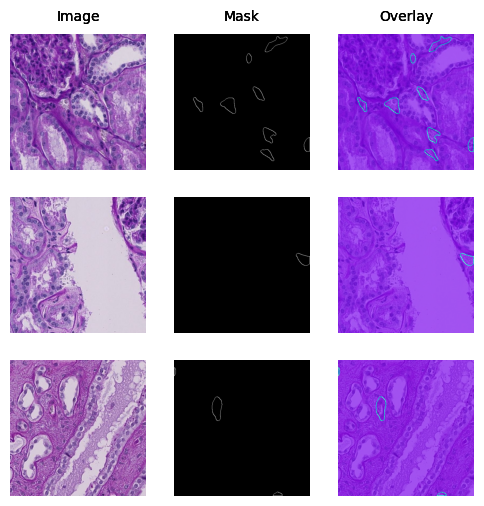

In [18]:
plot_sample(dataset, 3)

Let's split our current dataset into training data and validation data

In [19]:
train_data, val_data = random_split(dataset, [0.8, 0.2])

In [20]:
len(train_data)

1307

In [21]:
len(val_data)

326

Now, it's turn to create our DataLoader.
DataLoader is an iterable that abstracts the complexity of how we input the data to the model.

# The model: Mask2Former
[Mask2Former](https://huggingface.co/docs/transformers/main/model_doc/mask2former) is an improved version of [MaskFormer](https://huggingface.co/docs/transformers/model_doc/maskformer), a model which addresses semantic segmentation with a mask classification paradigm instead of performing classic pixel-level classification, Mask2Former extends this to instance segmentation by further improving the neural network architecture. 

In short, Mask2Former is defined as a unified framework for panoptic, instance and semantic segmentation and features significant performance and efficiency improvements over MaskFormer.

In [22]:
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = Mask2FormerForUniversalSegmentation.from_pretrained('facebook/mask2former-swin-small-coco-instance',
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-coco-instance and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([81, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([81]) in the checkpoint and torch.Size([2]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([81]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}


train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [24]:
# Trainer
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # using binary segmentation (e.g., 0 for background, 1 for foreground)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

train_losses = []
val_losses = []
train_running_loss = 0.0
val_running_loss = 0.0
num_samples = 0

for epoch in range(4):
    print("Epoch:", epoch)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
              pixel_values=batch["pixel_values"].to(device),
              mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
              class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )

        # Backward propagation
        loss = outputs.loss
        loss.backward()

        batch_size = batch["pixel_values"].size(0)
        train_running_loss += loss.item()
        num_samples += batch_size
        
        train_losses.append(loss.item())

        if idx % 100 == 0:
            print("Train loss:", train_running_loss/num_samples)                    

        # Optimization
        optimizer.step()
    
    model.eval()
    for idx, batch in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            outputs = model(
                  pixel_values=batch["pixel_values"].to(device),
                  mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                  class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )


            loss = outputs.loss

            batch_size = batch["pixel_values"].size(0)
            val_running_loss += loss.item()
            num_samples += batch_size

            val_losses.append(loss.item())

            if idx % 10 == 0:
                print("Validation loss:", val_running_loss/num_samples)               


torch.cuda.empty_cache()            

Let's use 2 GPUs!
Epoch: 0


  0%|          | 0/164 [00:00<?, ?it/s]

Train loss: 5.226739406585693
Train loss: 3.272820536452945


  0%|          | 0/41 [00:00<?, ?it/s]

Validation loss: 0.01883757558612316
Validation loss: 0.20307615546769994
Validation loss: 0.3665071170612917
Validation loss: 0.5133554464751118
Validation loss: 0.6461016157983055
Epoch: 1


  0%|          | 0/164 [00:00<?, ?it/s]

Train loss: 2.6196250032172705
Train loss: 2.7911811822362242


  0%|          | 0/41 [00:00<?, ?it/s]

Validation loss: 0.36604584508867405
Validation loss: 0.43680877131231555
Validation loss: 0.5053110693412398
Validation loss: 0.5694474659420765
Validation loss: 0.6296630907263117
Epoch: 2


  0%|          | 0/164 [00:00<?, ?it/s]

Train loss: 2.5613181382763583
Train loss: 2.6605721816866783


  0%|          | 0/41 [00:00<?, ?it/s]

Validation loss: 0.45425663148438244
Validation loss: 0.4992947155916238
Validation loss: 0.5427881678154991
Validation loss: 0.5841760819345508
Validation loss: 0.6249031091033257
Epoch: 3


  0%|          | 0/164 [00:00<?, ?it/s]

Train loss: 2.5250381153325137
Train loss: 2.596665710748673


  0%|          | 0/41 [00:00<?, ?it/s]

Validation loss: 0.49672934553958537
Validation loss: 0.5287237279484073
Validation loss: 0.5600146969022293
Validation loss: 0.5905476769020878
Validation loss: 0.6204878940804196


In [25]:
train_losses

[41.81391525268555,
 22.33102035522461,
 27.304662704467773,
 27.9759464263916,
 20.655166625976562,
 25.736047744750977,
 26.401790618896484,
 27.05788803100586,
 26.82992935180664,
 27.088390350341797,
 26.764184951782227,
 20.741525650024414,
 26.231794357299805,
 26.666156768798828,
 26.369083404541016,
 26.87990951538086,
 26.79582405090332,
 26.95629119873047,
 26.78443717956543,
 26.579702377319336,
 26.589033126831055,
 26.163734436035156,
 26.31739044189453,
 26.49401092529297,
 26.292316436767578,
 26.227746963500977,
 25.686779022216797,
 26.376617431640625,
 26.55231285095215,
 26.617752075195312,
 26.649873733520508,
 26.458314895629883,
 25.973751068115234,
 25.539363861083984,
 26.769859313964844,
 26.498058319091797,
 26.165050506591797,
 26.282285690307617,
 26.59923553466797,
 19.889421463012695,
 26.125213623046875,
 26.2579345703125,
 25.724348068237305,
 25.770063400268555,
 26.086652755737305,
 25.53989028930664,
 26.89700698852539,
 25.219802856445312,
 26.130828

<function matplotlib.pyplot.show(close=None, block=None)>

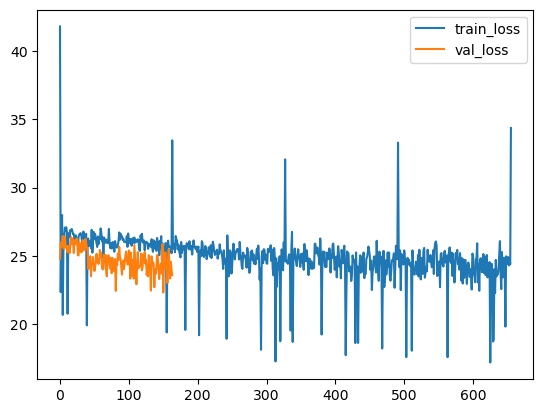

In [26]:
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show

In [27]:
torch.save(model.state_dict(), '/kaggle/working/hubmap.pth')

In [28]:
model.load_state_dict(torch.load('/kaggle/working/hubmap.pth'))

<All keys matched successfully>

In [29]:
img_path = os.path('/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif')
        
with rasterio.open(img_path) as image:
    image_array = image.read()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_23/1074454555.py:1 in <module>                                                    │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_23/1074454555.py'                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'module' object is not callable

# References
Rogge, N., Singh, S., & Dirik, A. (2023, January 19). Universal Image Segmentation with Mask2Former and OneFormer. HuggingFace. Retrieved May 29, 2023, from https://huggingface.co/blog/mask2former